In [1]:
import os

import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
def mode(x):
    """
    Args:
        x: 1D numpy array
        
    Return:
        scalar representing the mode of the arr
    """
    # count number of 1 in x
    one_sum = np.count_nonzero(x == 1)
    # count number of 0 in x
    zero_sum = np.count_nonzero(x == 0)
    # if the same length return 0.5
    if one_sum == zero_sum:
        return 0.5
    # return mode if a mode exists
    elif one_sum > zero_sum:
        return 1
    
    return 0

In [3]:
def logistic_sigmoid(x, betas, intercept):
    """
    Args: 
        x: Numpy arr containing the score [1-4] for each factor for each obeservation. Shape (1, n)
        betas: Numpy arr of betas extracted from logreg model. Shape (1, len(sample))
        intercept: number extracted from logreg model. Denoted as beta_0
    Returns:
        Numpy arr of shape (1, len(sample)). Probas from [0,1]
    """
    
    return 1 / (1 + np.exp(-(intercept + betas.T * x)))

In [4]:
def predict(X, betas, intercept):
    """
    Args:
        X: Dataframe with cultures that we want to make predicitions for. Shape (m, n)
        betas: array contains a beta for each factor. Extracted from Logreg model. Shape (1, n) 
        intercept: float extracted from logreg model. 
    Return:
        y_hat: arr with predictions. Each element is in the set {0, 1, 0.5}
    """
    y_hat= []
    
    for index, row in X.iterrows():
        # convert row into np array
        row_as_np = np.array(row)
        # get probabilities from logistic sigmoid
        probas = logistic_sigmoid(row, np.array(betas), intercept)
        # map probas to [0, 1]. If proba > 0.5 map to 1 else map to 0
        mapped = np.array(list(map(lambda x: 1 if x>=0.5 else 0, probas)))
        # get the mode of the mapped probas
        pred = mode(mapped)
        # add pred into y_hat
        y_hat.append(pred)
        
    return y_hat
        

In [5]:
def train_n_iters(X, y, n_iters=50):
    """
    Trains logistic regression model on different
    train and test sets. 
    
    Args:
        X: dataset with all obeservations. Shape (m, n)
        y: target values. Shape (m,)
        n_iters: number of iteration or number of models that 
        will be trained. Epochs is an integer
    
    Returns:
        results: Dataframe that contains f1_score, accuracy, precission, recall, true-positive, true-negative,
        false-positive, false-negative. Each row represent the ith iteration
        
        
    """
    
    
    res = pd.DataFrame()
    
    for i in range(0, n_iters+1): 
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.55)
        # init logistic regression
        logreg = LogisticRegression()
        # fit model
        logreg.fit(X_train, y_train)
        # prediction for the current dataset
        y_pred = predict(X_test, logreg.coef_[0], logreg.intercept_)
        # get metrics
        accuracy = accuracy_score(y_test,y_pred)
        precission = precision_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted') 
        recall = recall_score(y_test, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        tp = conf_matrix[1][1] # true positive
        tn = conf_matrix[0][0] # true negative
        fp = conf_matrix[1][0] # false positive
        fn = conf_matrix[0][1] # false negative
        
        ith_row = {"accuracy": accuracy, "precision": precission, 
                   "f1_score": f1, "recall": recall, "true_positive": tp, "true_negative": tn, 
                  "false_positive": fp, "false_negative": fn, 'max_beta': max(logreg.coef_[0]), 
                   'min_beta': min(logreg.coef_[0]), 'intercept': logreg.intercept_[0]}
        
        res = res.append(ith_row, ignore_index=True)
        
    return res

In [6]:
CSV_LOCATION = "peace_sys.csv"

In [7]:
df = pd.read_csv(CSV_LOCATION)

In [8]:
VARS = {'ID1.1Over' : 'Overarching Identity', 'Int2.4Hist' : 'Interconnected Historically', 
        'Int2.2Econ' : 'Interconnected Economically', 'Dep3.3Econ' : 'Interdependent Economically', 
        'Dep3.2Ecol' : 'Interdependent Ecologically', 'NWNorm5.1': 'Non-Warring Norms', 
        'NWVal4.1' : 'Non-Warring Values', 'SymP6': 'Peace Symbols', 'RitP6' : 'Peace Rituals', 
        'CM8.5Peace' : 'Peaceful Conflict Management Overall'}

In [9]:
y = df['PSysRec']

In [10]:
X = df[VARS.keys()].replace(9, np.nan)
X = X.fillna(X.mean())

In [11]:
X.head(5)

,ID1.1Over,Int2.4Hist,Int2.2Econ,Dep3.3Econ,Dep3.2Ecol,NWNorm5.1,NWVal4.1,SymP6,RitP6,CM8.5Peace
0,2.532258,2.913043,2.984375,2.689655,2.5,3.083333,3.171875,2.923077,2.565217,3.1
1,1.000000,2.913043,1.000000,3.000000,2.5,3.083333,4.000000,2.000000,2.000000,3.1
2,2.532258,2.913043,2.984375,1.000000,1.0,3.083333,2.500000,2.923077,2.565217,3.1
3,2.532258,2.913043,3.000000,3.000000,3.0,3.083333,3.000000,2.923077,2.565217,3.1
4,2.532258,4.000000,4.000000,3.000000,2.0,3.083333,3.000000,3.000000,2.565217,3.1


In [12]:
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [13]:
res = train_n_iters(X, y, n_iters=100)

/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankpalma/Projects/Peace_System/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [14]:
res

,accuracy,f1_score,false_negative,false_positive,intercept,max_beta,min_beta,precision,recall,true_negative,true_positive
0,0.653846,0.516995,0.0,9.0,-9.786480,1.013498,-0.250098,0.427515,0.653846,17.0,0.0
1,0.653846,0.516995,0.0,9.0,-9.205965,1.044032,-0.448589,0.427515,0.653846,17.0,0.0
2,0.615385,0.468864,0.0,10.0,-17.256365,0.871606,0.348635,0.378698,0.615385,16.0,0.0
3,0.692308,0.566434,0.0,8.0,-10.381775,0.914878,-0.051701,0.479290,0.692308,18.0,0.0
4,0.576923,0.422139,0.0,11.0,-17.012621,0.938503,0.216913,0.332840,0.576923,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
96,0.576923,0.422139,0.0,11.0,-16.848016,1.091688,0.224539,0.332840,0.576923,15.0,0.0
97,0.576923,0.422139,0.0,11.0,-15.270002,1.006336,-0.036810,0.332840,0.576923,15.0,0.0
98,0.692308,0.566434,0.0,8.0,-10.722014,0.936311,-0.162257,0.479290,0.692308,18.0,0.0
99,0.615385,0.468864,0.0,10.0,-17.353347,1.234815,0.199424,0.378698,0.615385,16.0,0.0


In [38]:
np.mean(res['max_beta']), min(res['intercept'])

(0.9454287041168777, -18.98939738333916)

In [15]:
mean_f1_score = np.round(res['f1_score'].mean(), 3) 
mean_accuracy_score = np.round(res['accuracy'].mean(), 3)
mean_precision_score = np.round(res['precision'].mean(), 3)
mean_recall_score = np.round(res['recall'].mean(), 3) 

In [16]:
print("Mean F1 Score: " + str(mean_f1_score))
print("Mean Accuracy: " + str(mean_accuracy_score))
print("Mean Precision: " + str(mean_precision_score))
print("Mean Recall: " + str(mean_recall_score))

Mean F1 Score: 0.528
Mean Accuracy: 0.661
Mean Precision: 0.441
Mean Recall: 0.661


In [17]:
mean_tn = np.round(res['true_negative'].mean(), 3)
mean_tp = np.round(res['true_positive'].mean(), 3)
mean_fn = np.round(res['false_negative'].mean(), 3)
mean_fp = np.round(res['false_positive'].mean(), 3)

In [18]:
mean_conf_matrix = [[mean_tn, mean_fn], [mean_fp, mean_tp]]

In [19]:
mean_conf_matrix

[[17.178, 0.0], [8.822, 0.0]]

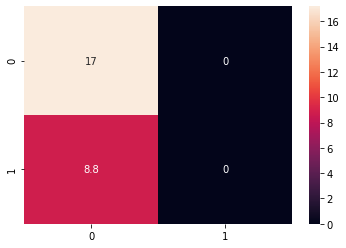

In [20]:
mean_conf_matrix_plot = sns.heatmap(mean_conf_matrix, annot=True)

In [21]:
# save confusion matrix
mean_conf_matrix_plot.get_figure().savefig("mean_confusion_matrix.png")

In [22]:
mean_metrics = {
"Metrics": {   "f1_score": mean_f1_score, "accuracy": mean_accuracy_score,
    "precision": mean_precision_score, "recall": mean_recall_score}
}

In [23]:
mean_metrics = pd.DataFrame({
    "Metric": ['F1 Score', 'Precission', 'Recall', 'Accuracy'], 
    "Score": [mean_f1_score, mean_precision_score, mean_recall_score, mean_accuracy_score]
})

In [24]:
metric_names = ['F1 Score', 'Precission', 'Recall', 'Accuracy']
mean_scores = [mean_f1_score, mean_precision_score, mean_recall_score, mean_accuracy_score]

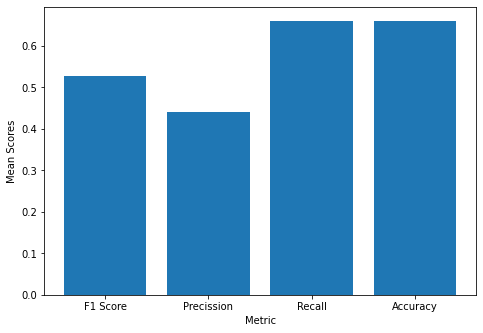

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(metric_names, mean_scores)
plt.ylabel('Mean Scores')
plt.xlabel('Metric')
plt.show()

In [26]:
res.to_csv("100_iter_result.csv")

In [27]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.55)
# init logistic regression
logreg = LogisticRegression()
# fit model
logreg.fit(X_train, y_train)
# prediction for the current dataset
y_pred = predict(X_test, logreg.coef_[0], logreg.intercept_)
# get metrics

In [28]:
y_pred

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
logreg.coef_[0]

array([ 0.32485407,  0.16202556,  0.86554674,  0.40957182,  0.64544691,
        0.32093751,  0.49108315, -0.17980451, -0.31572712,  0.86242653])

In [30]:
logreg.intercept_

array([-11.06992734])

In [31]:
row_1 = [1.000000, 2.913043, 1.000000, 3.000000, 2.5, 3.083333, 4.000000, 2.000000, 2.000000, 3.1]

In [32]:
logistic_sigmoid(row_1, logreg.coef_[0], logreg.intercept_)

array([2.15508603e-05, 2.49667680e-05, 3.70064769e-05, 5.32099522e-05,
       7.81884783e-05, 4.18921531e-05, 1.11030484e-04, 1.08695286e-05,
       8.28229994e-06, 2.25626237e-04])

In [37]:
res.to_excel("skewed_to_zero.xlsx")